# MachineMax Technical Test

## Imports

In [1]:
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import random
import re
from enum import Enum
from tqdm import tqdm
from dataclasses import dataclass
from pykalman import KalmanFilter
from Codebase.utils2 import StateGenerator, RMSGenerator, IntervalGenerator, DataGenerator, States

## Data Generation

### Assumptions

Several assumptions had to be made regarding the data generation, these are as follows:

1. The RMS ranges for each state are predefined (and can be set as inputs to the RMSGenerator)
2. The transition between states is not instantaneous, and the vehicle cannot transition directly from the 'ACTIVE' state to 'OFF' or vice-versa.
3. There will be intermittent periods of idling during the 'ACTIVE' state to emulate the vehicle stopping/starting.
4. The RMS values for the 'OFF' state 

Keep in mind that these are assumptions, and in a real-world situation, it would be better to have some sample data to guide the choice of distributions. The actual distribution of vibration magnitude might not strictly follow these distributions and might be influenced by many factors such as the type of engine, the type of work being done, the terrain, and maintenance history among others.

In [16]:
# Defining parameters for the time series data
start_date = '2021-01-01 00:00:00'
end_date = '2021-01-01 02:00:00'
start_date = datetime.strptime(start_date, '%Y-%m-%d %H:%M:%S')
end_date = datetime.strptime(end_date, '%Y-%m-%d %H:%M:%S')
freq = '30s'
# Constants
DEFAULT_STATES = ['ACTIVE', 'IDLE', 'OFF']
DEFAULT_RMS_RANGES = {
    States.OFF: ('uniform', 0, 2),
    States.IDLE: ('normal', 250, 50),
    States.ACTIVE: ('lognormal', 6.2, 0.22)
}
DEFAULT_MIN_DURATION = 2
DEFAULT_MAX_DURATION = 250

In [17]:
test = end_date - start_date
test

datetime.timedelta(seconds=7200)

In [9]:
# Initialize the StateGenerator
states = [States.ACTIVE, States.IDLE, States.OFF]
# Define the transition probabilities
transition_probabilities = {
    States.OFF: {
        States.OFF: 0.5,
        States.IDLE: 0.5,
        States.ACTIVE: 0.0
    },
    States.IDLE: {
        States.OFF: 0.15,
        States.IDLE: 0.55,
        States.ACTIVE: 0.3
    },
    States.ACTIVE: {
        States.OFF: 0.0001,
        States.IDLE: 0.15,
        States.ACTIVE: 0.8499
    }
}
state_generator = StateGenerator(states, transition_probabilities)

In [10]:
# Initialize the IntervalGenerator
state_duration_map = {
    States.OFF: (180, 480),
    States.IDLE: (30, 181),
    States.ACTIVE: (30, 481)
}
interval_generator = IntervalGenerator(state_duration_map)

In [11]:
# Initialize the RMSGenerator
rms_generator = RMSGenerator(DEFAULT_RMS_RANGES)

In [12]:
kf = KalmanFilter(
    transition_matrices=[1],
    observation_matrices=[1],
    initial_state_mean=0,
    initial_state_covariance=1,
    observation_covariance=.5,
    transition_covariance=10
)

In [ ]:
generator = DataGenerator(
    state_generator,
    rms_generator,
    interval_generator,
    # kf
)
df = generator.generate_time_series_data(start_date, end_date, freq)

### Plotting Data

In [101]:
df_filtered = df[df['state_change'] == True]
state_counts = df['state'].value_counts()
state_counts

state
States.ACTIVE    214
States.OFF        49
States.IDLE       26
Name: count, dtype: int64

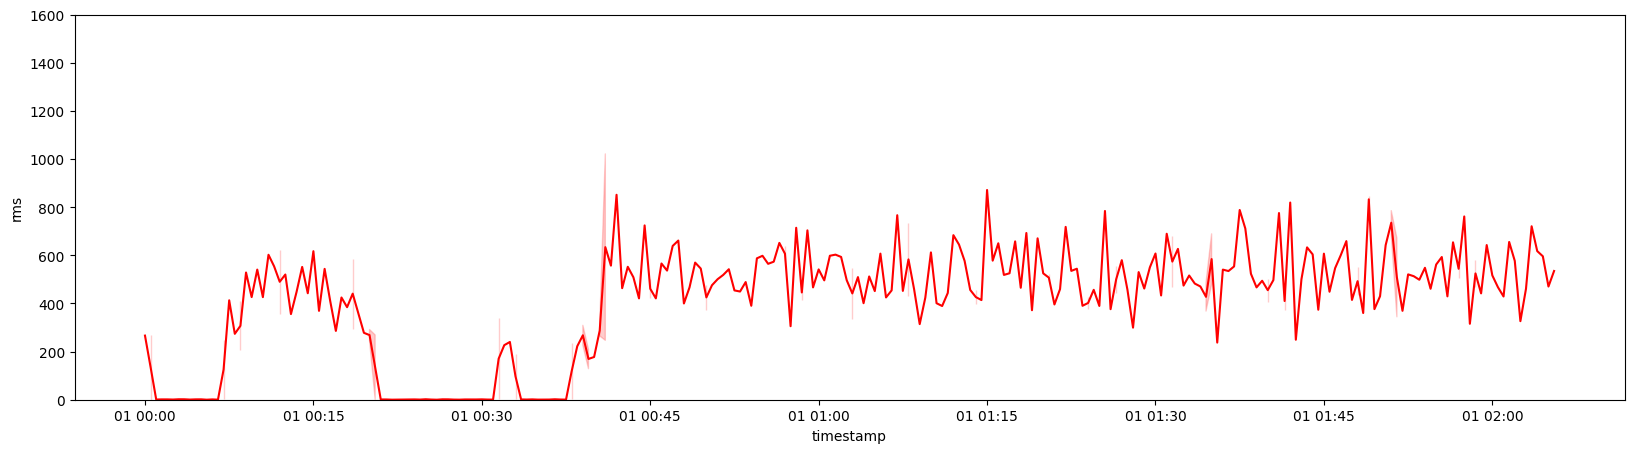

In [100]:
ax, fig = plt.subplots(figsize=(20, 5))
sns.lineplot(x='timestamp', y='rms', data=df, ax=fig, color='red')
# sns.lineplot(x='timestamp', y='rms_smoothed', data=df, ax=fig, color='blue', linestyle='--')
plt.ylim([0, 1600])
plt.show()

### Saving Data

## Next Steps
---
1. Produce several datasets using the data generator:
- You should vary the rms_value ranges for each dataset to simulate sensors being placed on different vehicles

2. Train an initial model on one of the datasets:
- Verify model performance on test set
- Verify model performance on additional datasets, to test robustness of the model
- If it can't generalise to new contexts, retrain the model with additional data

3. If time available, go back to data generation and try different filtering methods

In [ ]:
# This creates a 
df = pd.read_csv('./Generated Data/dataset_0.csv')

In [ ]:
import numpy as np
import pandas as pd
import random

# Define constants for our states
OFF, IDLE, ACTIVE, TRANSITION = 0, 1, 2, 3
STATE_NAMES = {OFF: 'OFF', IDLE: 'IDLE', ACTIVE: 'ACTIVE', TRANSITION: 'TRANSITION'}

def generate_state_data(state, num_points):
    if state == OFF:
        return np.random.normal(loc=0.5, scale=0.1, size=num_points)
    elif state == IDLE:
        return np.random.normal(loc=2, scale=0.2, size=num_points)
    elif state == ACTIVE:
        return np.random.normal(loc=4, scale=0.3, size=num_points)
    elif state == TRANSITION:
        return np.random.normal(loc=1.5, scale=0.2, size=num_points)

def generate_timestamps(start, end, n):
    return np.linspace(start, end, num=n)

def generate_time_series_data(num_transitions, points_per_state):
    # We start in the OFF state
    current_state = OFF
    timestamps = []
    magnitudes = []
    states = []

    for i in range(num_transitions):
        # Add data for the current state
        num_points = random.randint(points_per_state[0], points_per_state[1])
        magnitudes.extend(generate_state_data(current_state, num_points))
        timestamps.extend(generate_timestamps(i, i+1, num_points))
        states.extend([STATE_NAMES[current_state]] * num_points)

        # Add data for the transition
        num_points = random.randint(points_per_state[0], points_per_state[1])
        magnitudes.extend(generate_state_data(TRANSITION, num_points))
        timestamps.extend(generate_timestamps(i+1, i+2, num_points))
        states.extend([STATE_NAMES[TRANSITION]] * num_points)

        # Move to the next state
        if current_state == OFF:
            current_state = ACTIVE
        else:
            current_state = OFF

    return pd.DataFrame({'timestamp': timestamps, 'rms': magnitudes, 'state': states})

# Call the function
df = generate_time_series_data(10, (50, 100))
print(df.head())


   timestamp       rms state
0   0.000000  0.557998   OFF
1   0.014925  0.503119   OFF
2   0.029851  0.522221   OFF
3   0.044776  0.331928   OFF
4   0.059701  0.484900   OFF


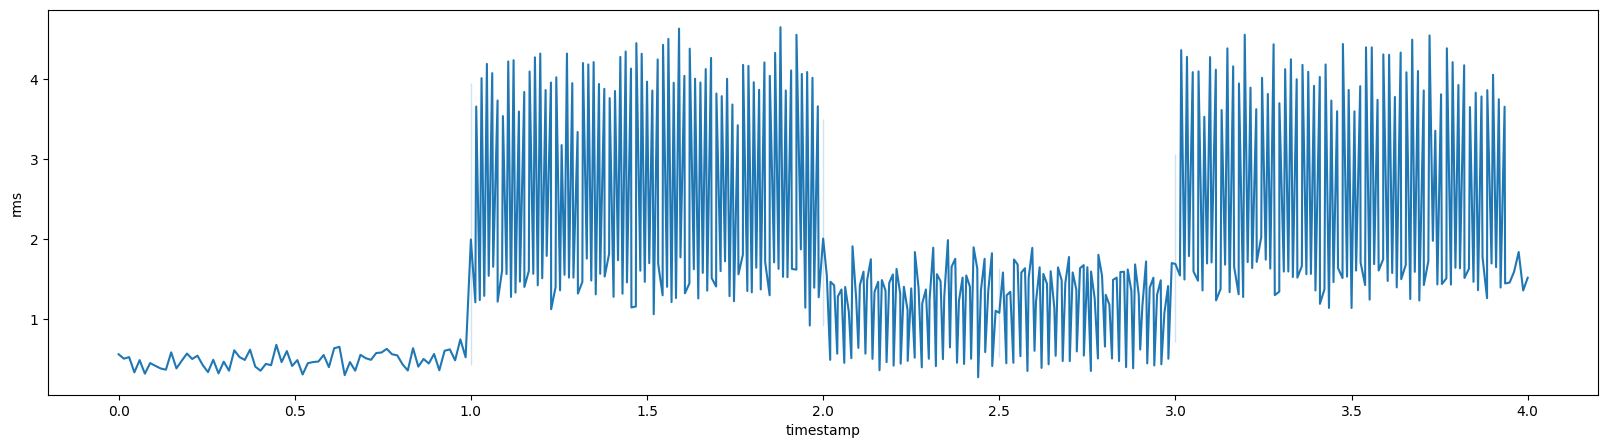

In [ ]:
ax, fig = plt.subplots(figsize=(20, 5))
sns.lineplot(x='timestamp', y='rms', data=df[:500], ax=fig)
plt.show()

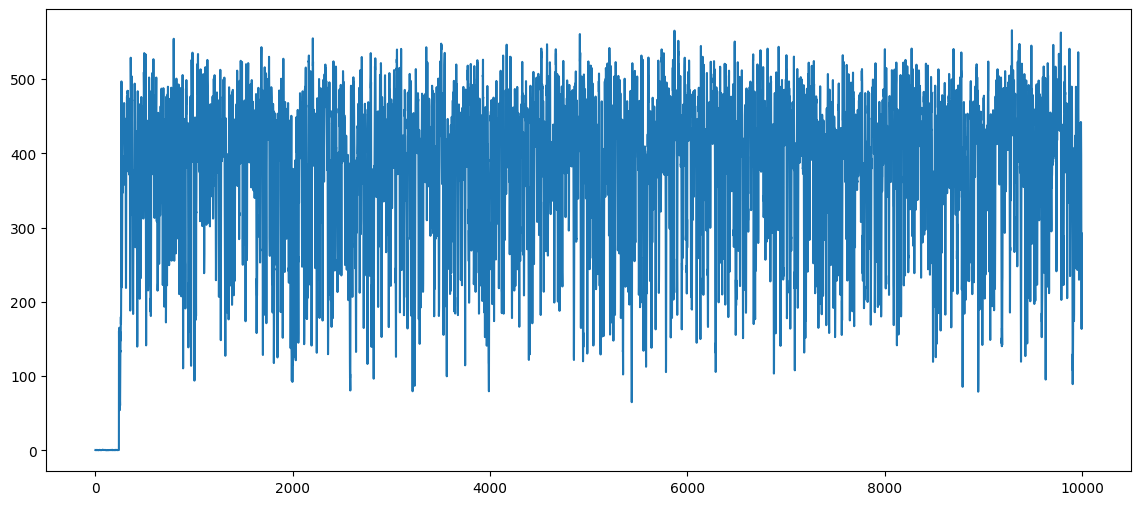

In [ ]:
import numpy as np

# Define constants for each state
STATE_OFF = "OFF"
STATE_IDLE = "IDLE"
STATE_ACTIVE = "ACTIVE"

# Define vibration ranges for each state
RANGE_OFF = (0, 1)
RANGE_IDLE = (1, 300)
RANGE_ACTIVE = (290, 600)

# Define transition probabilities
TRANSITIONS = {
    STATE_OFF: {STATE_IDLE: 1.0},  # OFF can only go to IDLE
    STATE_IDLE: {STATE_OFF: 0.05, STATE_ACTIVE: 0.95},  # IDLE can go to OFF or ACTIVE
    STATE_ACTIVE: {STATE_IDLE: 0.00005, STATE_ACTIVE: 0.99995}  # ACTIVE can go to IDLE or stay ACTIVE
}

# Define rate parameters for the exponential distribution of each state duration
DURATION_RATES = {
    STATE_OFF: 1/1000,
    STATE_IDLE: 1/100,
    STATE_ACTIVE: 1/700
}

def get_next_state(current_state):
    return np.random.choice(
        list(TRANSITIONS[current_state].keys()), 
        p=list(TRANSITIONS[current_state].values())
    )

def generate_state_data(state, num_steps):
    min_val, max_val = {
        STATE_OFF: RANGE_OFF,
        STATE_IDLE: RANGE_IDLE,
        STATE_ACTIVE: RANGE_ACTIVE
    }[state]

    return np.random.uniform(min_val, max_val, num_steps)

def generate_idle_noise(num_steps):
    return np.random.normal(0, 0.1, num_steps)

def smooth_data(data, window_size=5):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

def generate_time_series(num_steps, window_size=5):
    data = []
    states = []
    current_state = STATE_OFF
    while len(data) < num_steps:
        current_duration = np.random.exponential(1/DURATION_RATES[current_state])
        current_duration = max(1, int(current_duration))  # Ensure duration is at least 1
        current_data = generate_state_data(current_state, current_duration)

        if current_state == STATE_ACTIVE:
            idle_periods = current_duration // 10  # Introduce brief idle periods every 10 steps
            for _ in range(idle_periods):
                idle_start = np.random.randint(0, current_duration-5)  # Make sure the idle period starts well before the end
                idle_duration = np.random.randint(1, min(5, current_duration - idle_start))  # Make sure the idle period ends before the total duration
                idle_end = idle_start + idle_duration
                current_data[idle_start:idle_end] = generate_state_data(STATE_IDLE, idle_duration)

        # Apply smoothing to current data
        current_data = smooth_data(current_data, window_size)
        current_duration = len(current_data)  # Update duration based on smoothed data
        
        data.extend(current_data)
        states.extend([current_state] * current_duration)

        current_state = get_next_state(current_state)
    
    return np.array(data[:num_steps]), np.array(states[:num_steps])

# Generate synthetic time-series data
data, states = generate_time_series(10000)

# For visualization purposes:
import matplotlib.pyplot as plt
plt.figure(figsize=(14,6))
plt.plot(data)
plt.show()
